In [0]:
!wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip 
#!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=0B7EVK8r0v71pZjFTYXZWM3FlRnM' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=0B7EVK8r0v71pZjFTYXZWM3FlRnM" -O img_align_celeba.zip && rm -rf /tmp/cookies.txt

--2020-01-27 14:58:07--  https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.24.185
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.24.185|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1443490838 (1.3G) [application/zip]
Saving to: ‘celeba.zip’

celeba.zip          100%[===================>]   1.34G  66.7MB/s    in 20s     

2020-01-27 14:58:28 (68.0 MB/s) - ‘celeba.zip’ saved [1443490838/1443490838]



In [0]:
!unzip -q celeba.zip

In [0]:
import numpy as np
import os
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.utils.data_utils import Sequence
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
import matplotlib.pyplot as plt

image_names = np.array(os.listdir('img_align_celeba'))

Using TensorFlow backend.


In [0]:
def add_gaussian_noise(img, mean, sigma):
  noise = np.random.normal(mean, sigma, (img.shape[0], img.shape[1], 1))
  img += noise
  np.clip(img, 0.0, 1.0, img)

In [0]:
def add_dropout_noise(img, probability):
  rand = np.random.random((img.shape[0], img.shape[1]))
  img[rand < probability] = 0

In [0]:
def add_regional_noise(img, range):
  top_left_x = np.random.randint(img.shape[0]-range[0])
  top_left_y = np.random.randint(img.shape[1]-range[1])

  img[top_left_x:top_left_x+range[0], top_left_y:top_left_y+range[1]] = 0

In [0]:
class NoisySequence(Sequence):

    def __init__(self, image_names, batch_size, target_size, **kwargs):
        self.image_names = image_names
        self.batch_size = batch_size
        self.target_size = target_size
        self.kwargs = kwargs

    def __len__(self):
        return int(np.ceil(len(self.image_names) / float(self.batch_size)))

    def add_noise(self, img, kwargs):
      pass

    def __getitem__(self, idx):
        batch_x = self.image_names[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.image_names[idx * self.batch_size:(idx + 1) * self.batch_size]

        X_batch = []
        Y_batch = []
        for name in batch_x:
          image = load_img('img_align_celeba/' + name, target_size=self.target_size)
          image = img_to_array(image)/255.0
          noiseless = image.copy()
          self.add_noise(image, self.kwargs)
          X_batch.append(image)
          Y_batch.append(noiseless)
        
        return np.array(X_batch), np.array(Y_batch)

class Gaussian(NoisySequence):

    def __init__(self, image_names, batch_size, target_size, **kwargs):
        super().__init__(image_names, batch_size, target_size, **kwargs)

    def add_noise(self, img, kwargs):
      add_gaussian_noise(img, mean=kwargs['mean'], sigma=kwargs['sigma'])

class Dropout(NoisySequence):

    def __init__(self, image_names, batch_size, target_size, **kwargs):
        super().__init__(image_names, batch_size, target_size, **kwargs)

    def add_noise(self, img, kwargs):
      add_dropout_noise(img, probability=kwargs['probability'])

class Regional(NoisySequence):

    def __init__(self, image_names, batch_size, target_size, **kwargs):
        super().__init__(image_names, batch_size, target_size, **kwargs)

    def add_noise(self, img, kwargs):
      add_regional_noise(img, range=kwargs['range'])

In [0]:
image_size = (64,64)

In [0]:
def load_images(n):
  images = []
  for i,name in enumerate(image_names):
    if i >= n:
      break
    image = load_img('img_align_celeba/' + name, target_size=image_size)
    image = img_to_array(image)/255.0
    images.append(image)
  images = np.array(images)
  return images

images = load_images(9)
print("images.shape = {}".format(images.shape))

input_img = Input(shape=(image_size[0], image_size[1], 3))

images.shape = (9, 64, 64, 3)




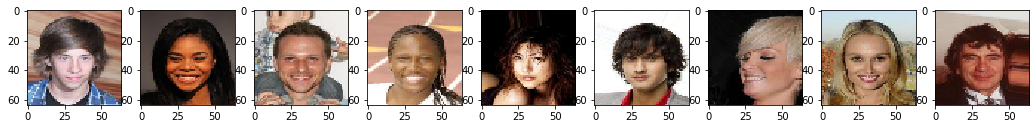

In [0]:
fig = plt.figure(figsize=(20,10))
nplot = 10
for count in range(1,nplot):
    ax = fig.add_subplot(1,nplot,count)
    ax.imshow(images[count-1])
plt.show()

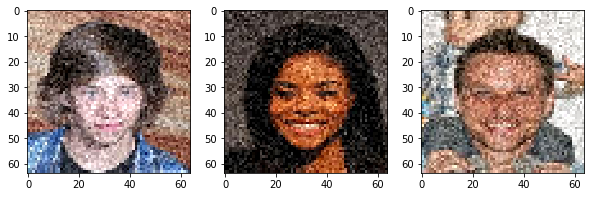

In [0]:
fig = plt.figure(figsize=(10,3))
for count in range(0,3):
    ax = fig.add_subplot(1,3,count+1)
    add_gaussian_noise(images[count], 0, 0.1)
    ax.imshow(images[count])
plt.show()

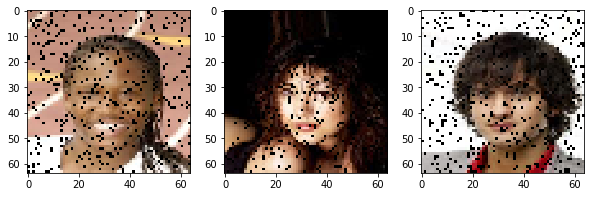

In [0]:
fig = plt.figure(figsize=(10,3))
for count in range(3,6):
    ax = fig.add_subplot(1,3,count-2)
    add_dropout_noise(images[count], 0.1)
    ax.imshow(images[count])
plt.show()

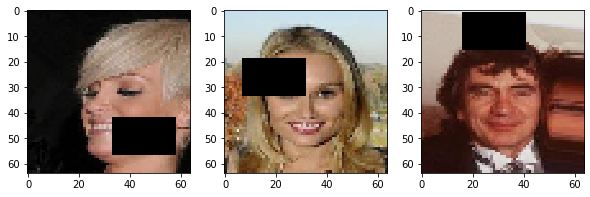

In [0]:
fig = plt.figure(figsize=(10,3))
for count in range(6,9):
    ax = fig.add_subplot(1,3,count-5)
    add_regional_noise(images[count], (15,25))
    ax.imshow(images[count])
plt.show()

In [0]:
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img) # 64x64x64
x = MaxPooling2D((2, 2), padding='same')(x) # 32x32x64
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x) # 32x32x128
x = MaxPooling2D((2, 2), padding='same')(x) # 16x16x128
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x) # 16x16x128
encoded = MaxPooling2D((2, 2), padding='same')(x) # 8x8x128
x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
X_train_gauss = Gaussian(image_names=image_names[0:100000], batch_size=128, target_size=image_size, mean=0.0, sigma=0.1)

In [0]:
# autoencoder.fit_generator(generator=X_train_gauss, epochs=100, use_multiprocessing=True)
autoencoder.load_weights('gauss_weights.h5')

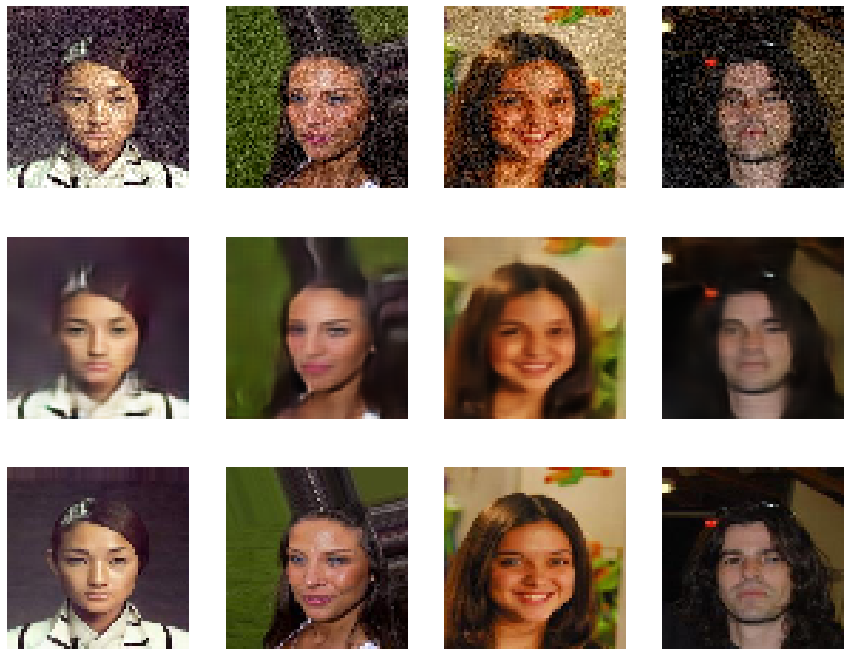

In [0]:
def load_images(start, end):
  images = []
  for i in range(start, end):
    image = load_img('img_align_celeba/' + image_names[i], target_size=image_size)
    image = img_to_array(image)/255.0
    images.append(image)
  images = np.array(images)
  return images

start_ind = np.random.randint(100000, image_names.shape[0]-4)
test_images = load_images(start_ind, start_ind+4)
noiseless = test_images.copy()
for image in test_images:
  add_gaussian_noise(image, 0.0, 0.1)

predictions = autoencoder.predict(test_images)

plt.figure(figsize=(15,12))
for i in range(4):
  plt.subplot(3,4,i+1)
  plt.imshow(test_images[i])
  plt.axis('off')

for i in range(4):
  plt.subplot(3,4,i+5)
  plt.imshow(predictions[i])
  plt.axis('off')

for i in range(4):
  plt.subplot(3,4,i+9)
  plt.imshow(noiseless[i])
  plt.axis('off')

In [0]:
#autoencoder.save_weights('gauss_weights.h5')

In [0]:
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img) # 64x64x64
x = MaxPooling2D((2, 2), padding='same')(x) # 32x32x64
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x) # 32x32x128
x = MaxPooling2D((2, 2), padding='same')(x) # 16x16x128
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x) # 16x16x128
encoded = MaxPooling2D((2, 2), padding='same')(x) # 8x8x128
x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
autoencoder_dropout = Model(input_img, decoded)
autoencoder_dropout.compile(optimizer='adam', loss='binary_crossentropy')

In [0]:
X_train_dropout = Dropout(image_names=image_names[0:100000], batch_size=128, target_size=image_size, probability=0.1)

In [0]:
#autoencoder_dropout.fit_generator(generator=X_train_dropout, epochs=100, use_multiprocessing=True)
autoencoder_dropout.load_weights('dropout_weights.h5')

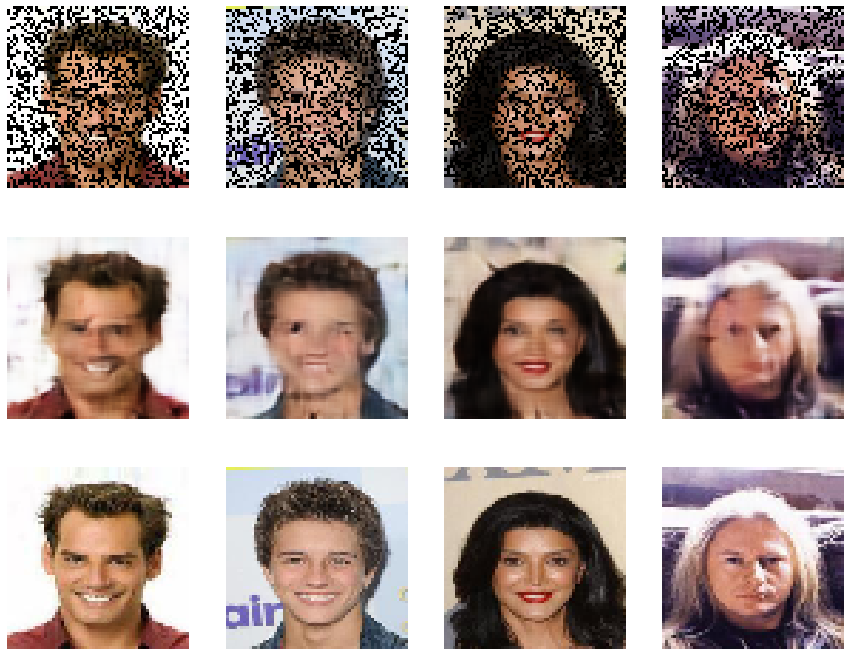

In [0]:
start_ind = np.random.randint(100000, image_names.shape[0]-4)
test_images = load_images(start_ind, start_ind+4)
noiseless = test_images.copy()
for image in test_images:
  add_dropout_noise(image, 0.4)

predictions = autoencoder_dropout.predict(test_images)

plt.figure(figsize=(15,12))
for i in range(4):
  plt.subplot(3,4,i+1)
  plt.imshow(test_images[i])
  plt.axis('off')

for i in range(4):
  plt.subplot(3,4,i+5)
  plt.imshow(predictions[i])
  plt.axis('off')

for i in range(4):
  plt.subplot(3,4,i+9)
  plt.imshow(noiseless[i])
  plt.axis('off')

In [0]:
#autoencoder_dropout.save_weights('dropout_weights.h5')

In [0]:
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img) # 64x64x64
x = MaxPooling2D((2, 2), padding='same')(x) # 32x32x64
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x) # 32x32x128
x = MaxPooling2D((2, 2), padding='same')(x) # 16x16x128
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x) # 16x16x128
encoded = MaxPooling2D((2, 2), padding='same')(x) # 8x8x128
x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
autoencoder_regional = Model(input_img, decoded)
autoencoder_regional.compile(optimizer='adam', loss='binary_crossentropy')

In [0]:
X_train_regional = Regional(image_names=image_names[0:100000], batch_size=128, target_size=image_size, range=(15,25))

In [0]:
#autoencoder_regional.fit_generator(generator=X_train_regional, epochs=100, use_multiprocessing=True)
autoencoder_regional.load_weights('regional_weights.h5')

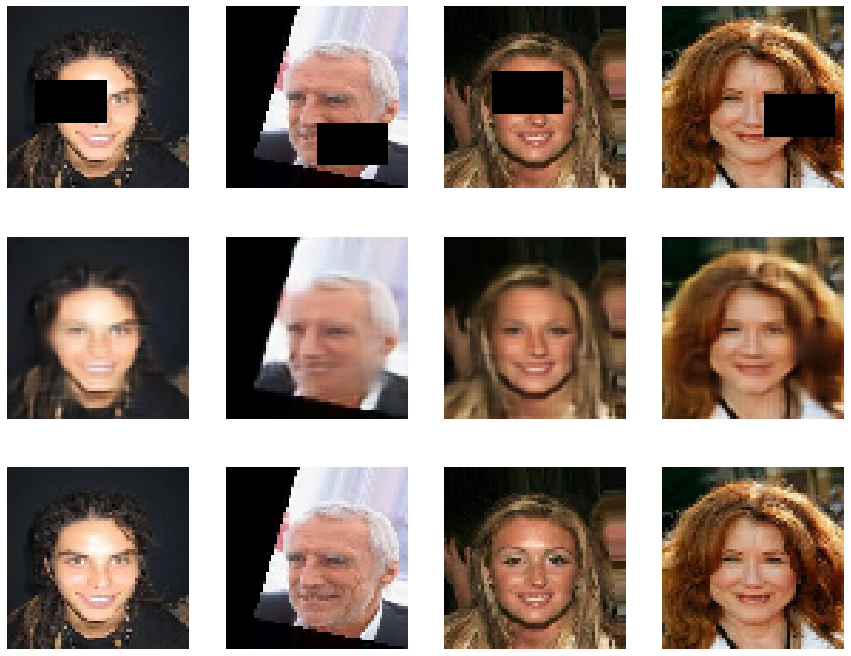

In [0]:
start_ind = np.random.randint(100000, image_names.shape[0]-4)
test_images = load_images(start_ind, start_ind+4)
noiseless = test_images.copy()
for image in test_images:
  add_regional_noise(image, (15,25))

predictions = autoencoder_regional.predict(test_images)

plt.figure(figsize=(15,12))
for i in range(4):
  plt.subplot(3,4,i+1)
  plt.imshow(test_images[i])
  plt.axis('off')

for i in range(4):
  plt.subplot(3,4,i+5)
  plt.imshow(predictions[i])
  plt.axis('off')

for i in range(4):
  plt.subplot(3,4,i+9)
  plt.imshow(noiseless[i])
  plt.axis('off')

In [0]:
#autoencoder_regional.save_weights('regional_weights.h5')